In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MODELO PREDICTIVO - LIGHTGBM PARA CLASIFICACIÓN

Con este modelo intentaremos clasificar en qué rango de ingresos se encuentra un mujer jefa de hogar monomarental partiendo de un conjunto de features determinantes. Luego, con el resultado podremos comparar cómo el cambio a nivel de género, entre otros, afectaría el outcome del mismo.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

df = pd.read_csv('/content/drive/MyDrive/ECH_2019.csv')

# df = pd.read_csv('ECH_2019.csv')

<Figure size 576x576 with 0 Axes>

In [3]:
# Reemplazar 0 que representan que no hay respuesta
no_data = {0: 'No hay dato', '0': 'No hay dato'}

mask = df.columns.difference(
    [
        'edad',
        'sueldo',
        'hijos en hogar',
        'hijos en otro hogar',
        'hijos en el extranjero',
        'suma_hijos',
        'barrio',
    ]
)

df[mask] = df[mask].replace(no_data).astype('category')

In [4]:
# Personas con edad suficiente para trabajar
df = df[~df['estado_laboral'].str.contains('Menores de 14 años')]

In [5]:
# Eliminar outliers en los sueldos
quantil_99 = df['sueldo'].quantile(0.99)
print(quantil_99)

df = df[df['sueldo'] < quantil_99]

quartil_1 = df['sueldo'].quantile(0.25)
quartil_3 = df['sueldo'].quantile(0.75)

iqr = quartil_3 - quartil_1

df = df[df['sueldo'] < quartil_3 + 1.5 * iqr]

df = df[df['sueldo'] > quartil_1 - 1.5 * iqr]

84000.0


In [6]:
pd.qcut(df['sueldo'], q=10, duplicates='drop').value_counts()

(-0.001, 11000.0]     59982
(11000.0, 20000.0]     9344
(29000.0, 47417.0]     8546
(20000.0, 29000.0]     7674
Name: sueldo, dtype: int64

In [7]:
# Creamos categorias con rangos de sueldos y edades
df['rango_sueldos'] = pd.qcut(df['sueldo'], q=10, duplicates='drop').cat.codes

df['rango_edades'] = pd.qcut(df['edad'], q=10).cat.codes

In [8]:
# Nos quedamos con las columnas que vamos a usar para el modelo
df = df.drop(['sueldo','edad'], axis=1)

# Removemos indice para tener un mejor orden de tratamiento
df = df.reset_index(drop=True)

In [9]:
# Feautures
X = df.drop('rango_sueldos', axis=1).to_numpy()
y = df['rango_sueldos']

print('X shape', X.shape, '\nY shape', y.shape)

X shape (85546, 29) 
Y shape (85546,)


In [10]:
# Definimos los feautures de test y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print('X shape', X.shape, '\nY shape', y.shape)

X shape (85546, 29) 
Y shape (85546,)


In [11]:
# Creamos el pipeline de ejecución
one_hot = OneHotEncoder(handle_unknown='ignore')
normalizer = Normalizer()

pipe = Pipeline(
    steps=[('encoder', one_hot),
           ('normalizer', normalizer),
           ('lightgbm', LGBMClassifier())
           ])

In [12]:
#Conocemos los hyparámetros que podemos personalizar
for key,value in LGBMClassifier().get_params().items():
    print(key,': ', value)

boosting_type :  gbdt
class_weight :  None
colsample_bytree :  1.0
importance_type :  split
learning_rate :  0.1
max_depth :  -1
min_child_samples :  20
min_child_weight :  0.001
min_split_gain :  0.0
n_estimators :  100
n_jobs :  -1
num_leaves :  31
objective :  None
random_state :  None
reg_alpha :  0.0
reg_lambda :  0.0
silent :  True
subsample :  1.0
subsample_for_bin :  200000
subsample_freq :  0


In [13]:
# Definimos los parámetros para el cross validation
param_grid = {
    'lightgbm__num_leaves':[31, 62, 70,100],
    'lightgbm__max_depth':[-1, 5, 10],
    'lightgbm__max_boosting_type':['gbdt', 'dart', 'goss', 'rf'],
    'lightgbm__n_estimators':[100,200,500],
    'lightgbm__objective': ['regression', 'multiclass', 'lambdarank']
}

In [14]:
# Creamos y determinamos el score del modelo
search = RandomizedSearchCV(pipe,
                      param_grid,
                      n_jobs=-1,
                      scoring='accuracy',
                      cv=5)

search.fit(X_train, y_train)

search.score(X_test, y_test)

0.7748207605985037

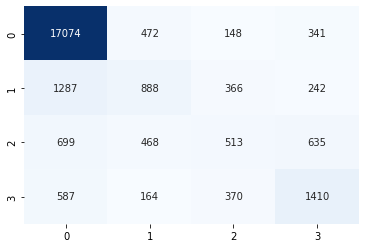

In [15]:
# Predicción
prediction = search.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

In [16]:
#Reporte de clasificación
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18035
           1       0.45      0.32      0.37      2783
           2       0.37      0.22      0.28      2315
           3       0.54      0.56      0.55      2531

    accuracy                           0.77     25664
   macro avg       0.55      0.51      0.53     25664
weighted avg       0.75      0.77      0.76     25664



In [17]:
search.best_params_

{'lightgbm__max_boosting_type': 'goss',
 'lightgbm__max_depth': -1,
 'lightgbm__n_estimators': 200,
 'lightgbm__num_leaves': 62,
 'lightgbm__objective': 'regression'}